# Hindcast timeseries analysis

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import pickle
import os
import statsmodels.api as sm
import pyhht
from scipy import signal, linalg, stats
from salishsea_tools import timeseries_tools, utilities, viz_tools, places
from matplotlib import gridspec, colors
from datetime import datetime, timedelta
from copy import deepcopy

%matplotlib inline

## Define local functions

In [3]:
def reshape_to_grid(data, gridx, gridy, shape, xslice=None, yslice=None, subfac=None):
    """
    """
    
    gridded = np.zeros(shape)
    for y, x, val in zip(gridy, gridx, data):
        gridded[..., y, x] = val
    if xslice is not None:
        gridded = gridded[..., slice(*yslice), :]
    if yslice is not None:
        gridded = gridded[..., slice(*xslice)]
    if subfac is not None:
        gridded = gridded[..., ::subfac, ::subfac]

    return gridded

In [4]:
def calc_EOF(
    timeseries, gridx, gridy, shape,
    xslice=None, yslice=None, subfac=None,
    timecut=None, spacecut=None, calc_varimax=False,
    nmode=10,
):
    """
    """
    
    EOF = {}
    
    # Detrend timeseries (Butterworth filter)
    Z = deepcopy(timeseries)
    if timecut is not None:
        for i, col in enumerate(Z.T):  # --- Temporal trend
            Z[:, i] = col - signal.filtfilt(*signal.butter(2, timecut), col)
    if spacecut is not None:
        for i, row in enumerate(Z):  # ----- Spatial trend
            Z[i, :] = row - signal.filtfilt(*signal.butter(2, spacecut), row)
            #Z[i, :] = row - row.mean()
    
    # Calculate EOFs
    A_prime, sqrtL, E_T = np.linalg.svd(Z, full_matrices=False)
    EOF['A'] = A_prime.dot(np.diag(sqrtL))
    EOF['var'] = (EOF['A']**2).sum(axis=0) / (EOF['A']**2).sum()
    
    # Reshape modes
    EOF['E'] = []
    for mode in range(nmode):
        EOF['E'].append(reshape_to_grid(
            E_T.T[:, mode], gridx, gridy, shape,
            xslice=xslice, yslice=yslice, subfac=subfac,
        ))
    
    # Varimax rotation
    if calc_varimax:
        R = varimax(EOF['A'])
        EOF['B'] = EOF['A'].dot(R)
        EOF['Rvar'] = (EOF['B']**2).sum(axis=0) / (EOF['B']**2).sum()
        
        # Reshape modes
        EOF['U'] = []
        for mode in range(5):
            EOF['U'].append(reshape_to_grid(
                E_T.T.dot(R)[:, mode], gridx, gridy, shape,
                xslice=xslice, yslice=yslice, subfac=subfac,
            ))
    
    return EOF

In [5]:
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    """From Wikipedia Varimax talk page
    https://en.wikipedia.org/wiki/Talk:Varimax_rotation
    """
    
    p, k = Phi.shape
    R = np.eye(k)
    d = 0
    for i in range(q):
        d_old = d
        Lambda = Phi.dot(R)
        u, s, vh = np.linalg.svd(Phi.T.dot(
            Lambda**3 - (gamma / p) *
            Lambda.dot(np.diag(np.diag(Lambda.T.dot(Lambda))))
        ))
        R = u.dot(vh)
        d = sum(s)
        if d_old != 0 and d/d_old < 1 + tol: break
    return R

## Extract hindcast slices
Extract and reshape indices

In [10]:
# Domain slice parameters
timerange = ['2015 Jan 1 00:00', '2015 Dec 31 23:59']
xslice, yslice = [100, 320], [380, 800]
zslice = 0
subfac = 5

# Create x and y indices
gridx, gridy = np.meshgrid(range(*xslice), range(*yslice))
gridx, gridy = gridx[::subfac, ::subfac], gridy[::subfac, ::subfac]

# Number of water points
nwater = np.prod(gridx.shape)

# Create reshaped tmask
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
tmask = mask.tmask.isel(t=0, z=zslice)
tmask[720:, :135] = 0  # mask out Discovery Passage nutrient plume
tmask = tmask.isel(y=slice(*yslice), x=slice(*xslice)).values.astype(bool)[::subfac, ::subfac].reshape(nwater)

# Reshape x and y indices
gridx = gridx.reshape(nwater)[tmask]
gridy = gridy.reshape(nwater)[tmask]

# Build time index
T = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')
time = T.time.sel(time=slice(*timerange)).values.astype('datetime64[s]').astype(datetime)

Load wind

In [11]:
# Load v wind
GEM = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
v_wind = GEM.v_wind.sel(time=slice(*timerange)).isel(gridY=j, gridX=i)

Predefine filenames, timeseries array, quantity, vertical method, and dump params

In [18]:
# Predefine filenames, timeseries array, quantity, vertical method, and dump params
filenames = timeseries_tools.make_filename_list(timerange, 'T', ftype='ptrc', model='nowcast-green')
qty = 'silicon'
vmethod = 'slice'
fieldID = qty + timerange[0].split()[0] + vmethod + str(zslice)
dumpfile = os.path.join('/ocean/bmoorema/research/MEOPAR/analysis-ben/data', fieldID + '_dump')

**STOP!** This is the main extraction step and will take some time. Execute when ready ...

In [19]:
# Loop through filenames
timeseries = np.empty((0, tmask.sum()))
bar = utilities.statusbar(f'Loading {qty} ...')
for filename in bar(filenames):
    
    # Load field from results file
    data = xr.open_dataset(filename).isel(y=slice(*yslice), x=slice(*xslice))[qty]
    
    # Either (1) extract horizontal slice at z index
    if vmethod is 'slice':
        
        # Extract slice and values
        data_reshape = data.isel(deptht=zslice).values
        
        # Reshape, subsample, and mask
        data_reshape = data_reshape[:, ::subfac, ::subfac].reshape(data.shape[0], nwater)[:, tmask]
    
    # Or (2) find depths of maximum values
    elif vmethod is 'max':
        data_reshape = np.take(
            data.deptht.values, data.values[:, :, ::subfac, ::subfac].argmax(axis=1),
        ).reshape(data.shape[0], nwater)[:, tmask]
    
    # Concatenate array onto timeseries array
    timeseries = np.concatenate((timeseries, data_reshape), axis=0)

# Dump timeseries results to pickle file
with open(dumpfile, 'wb') as output_file:
    pickle.dump({fieldID: timeseries}, output_file)

Loading silicon ... 100% (365 of 365) |####################################|Time: 0:20:21


If timeseries pickle files are already extracted, load them here.

In [14]:
# Load hindcast slices from pickle
timeseries = {}
for qty in ['vosaline', 'nitrate', 'silicon']:
    filename = f'/ocean/bmoorema/research/MEOPAR/analysis-ben/data/{qty}2016slice0_dump'
    with open(filename, 'rb') as fid:
        year = ''
        if qty is 'silicon':
            year = timerange[0].split()[0]
        timeseries[qty] = pickle.load(fid)[qty + year + 'slice0']

## Signal processing
Test various high pass filters for salinity

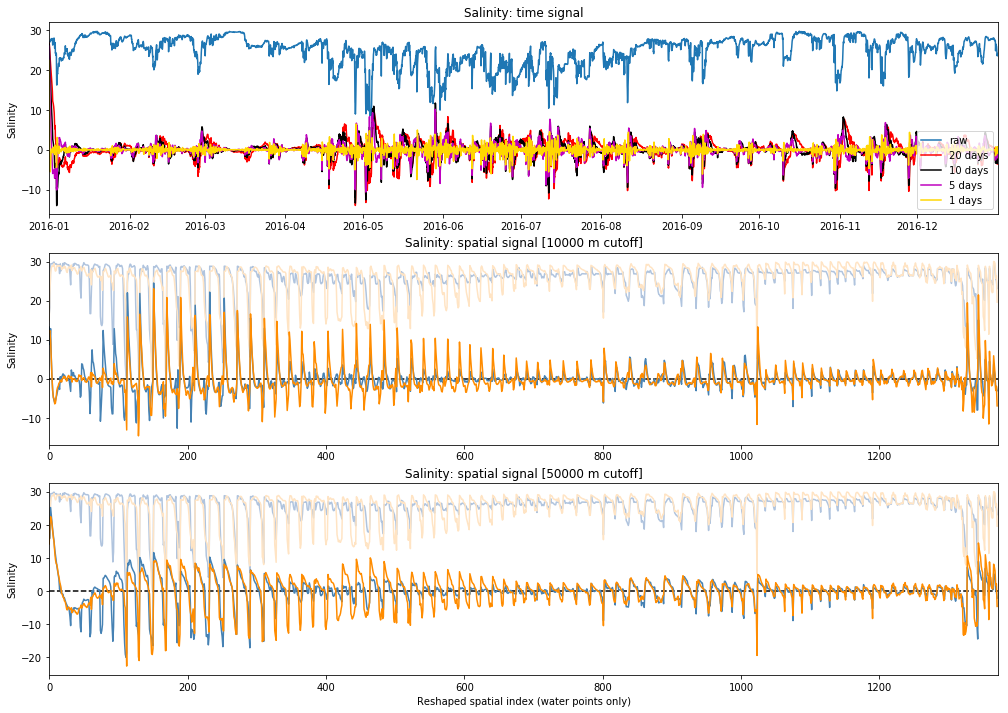

In [91]:
# Make figure
fig, axs = plt.subplots(3, 1, figsize=(17, 12))

# --- Top panel ---
axs[0].plot(time, timeseries['vosaline'][:, 100], label='raw')
axs[0].set_xlim(timerange)
axs[0].set_ylabel('Salinity')
axs[0].set_title('Salinity: time signal')
axs[2].set_xlabel('Reshaped spatial index (water points only)')

# Loop through lowcut
nyqst = 1 / 3600 / 2
for d, color in zip([20, 10, 5, 1], ['r', 'k', 'm', 'gold']):
    lowcut = 1 / 86400 / d
    y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['vosaline'][:, 100])
    axs[0].plot(time, y, color=color, label=f'{d} days')

# Legend
axs[0].legend(loc=4)

# --- Bottom panels ---
nyqst = 1 / 500 / 2
for ax, d in zip(axs[1:], [10000, 50000]):
    lowcut = 1 / d
    ax.set_ylabel('Salinity')
    ax.set_title(f'Salinity: spatial signal [{d} m cutoff]')
    ax.set_xlim([0, len(timeseries['vosaline'][0, :])])
    ax.plot([0, 1400], [0, 0], 'k--')
    ax.plot(timeseries['vosaline'][1800, :], color='lightsteelblue', label='raw')
    ax.plot(timeseries['vosaline'][2500, :], color='bisque', label='raw')
    y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['vosaline'][1800, :])
    ax.plot(y, color='steelblue')
    y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['vosaline'][2500, :])
    ax.plot(y, color='darkorange')

plt.show()

Test various high pass filters for nitrate

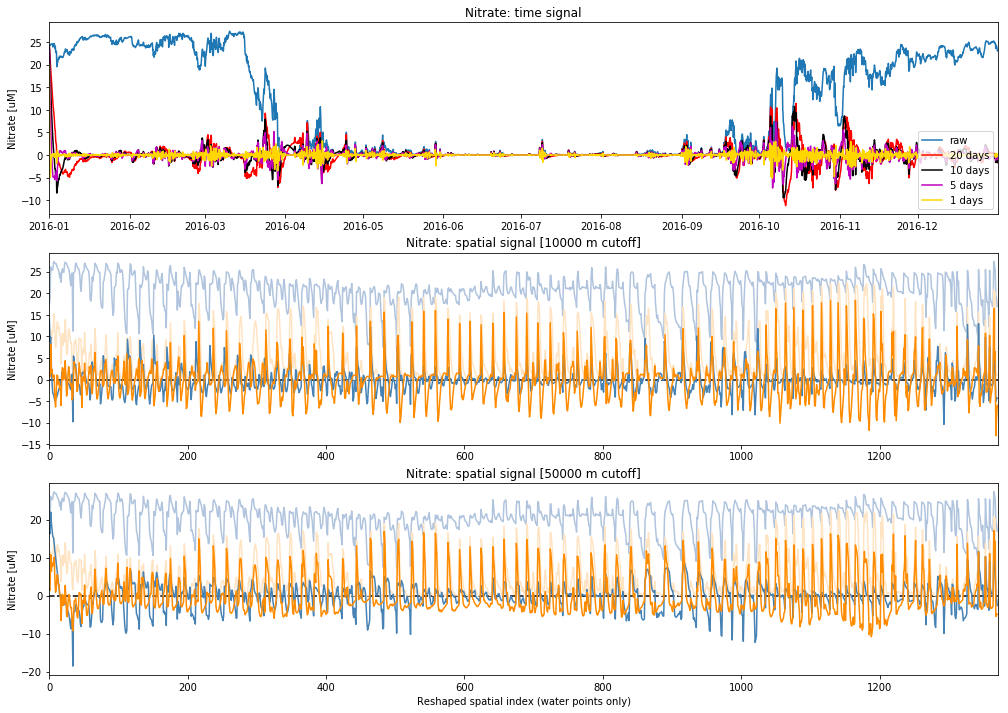

In [90]:
# Make figure
fig, axs = plt.subplots(3, 1, figsize=(17, 12))

# --- Top panel ---
axs[0].plot(time, timeseries['nitrate'][:, 100], label='raw')
axs[0].set_xlim(timerange)
axs[0].set_ylabel('Nitrate [uM]')
axs[0].set_title('Nitrate: time signal')
axs[2].set_xlabel('Reshaped spatial index (water points only)')

# Loop through lowcut
nyqst = 1 / 3600 / 2
for d, color in zip([20, 10, 5, 1], ['r', 'k', 'm', 'gold']):
    lowcut = 1 / 86400 / d
    y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['nitrate'][:, 100])
    axs[0].plot(time, y, color=color, label=f'{d} days')

# Legend
axs[0].legend(loc=4)

# --- Bottom panels ---
nyqst = 1 / 500 / 2
for ax, d in zip(axs[1:], [10000, 50000]):
    lowcut = 1 / d
    ax.set_ylabel('Nitrate [uM]')
    ax.set_title(f'Nitrate: spatial signal [{d} m cutoff]')
    ax.set_xlim([0, len(timeseries['nitrate'][0, :])])
    ax.plot([0, 1400], [0, 0], 'k--')
    ax.plot(timeseries['nitrate'][1800, :], color='lightsteelblue', label='raw')
    ax.plot(timeseries['nitrate'][2500, :], color='bisque', label='raw')
    y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['nitrate'][1800, :])
    ax.plot(y, color='steelblue')
    y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['nitrate'][2500, :])
    ax.plot(y, color='darkorange')

plt.show()

## EOF analysis
Calculate EOFs

In [27]:
# Loop through variables
EOF = {}
for qty in ['vosaline', 'nitrate', 'silicon']:

    # Lowpass filter params
    nyqst = 1 / 3600 / 2
    lowcut = 1 / 86400 / 30 # 30 days
    timecut = lowcut / nyqst
    nyqst = 1 / 500 / 2
    lowcut = 1 / 50000 # 50 km
    spacecut = lowcut / nyqst

    # Calculate EOFs
    EOF[qty] = calc_EOF(
        timeseries[qty], gridx, gridy, mask.nav_lon.shape,
        xslice=xslice, yslice=yslice, subfac=subfac,
        timecut=timecut, spacecut=spacecut, calc_varimax=False,
    )

### 10 km cutoff
Plot Hindcast PCs

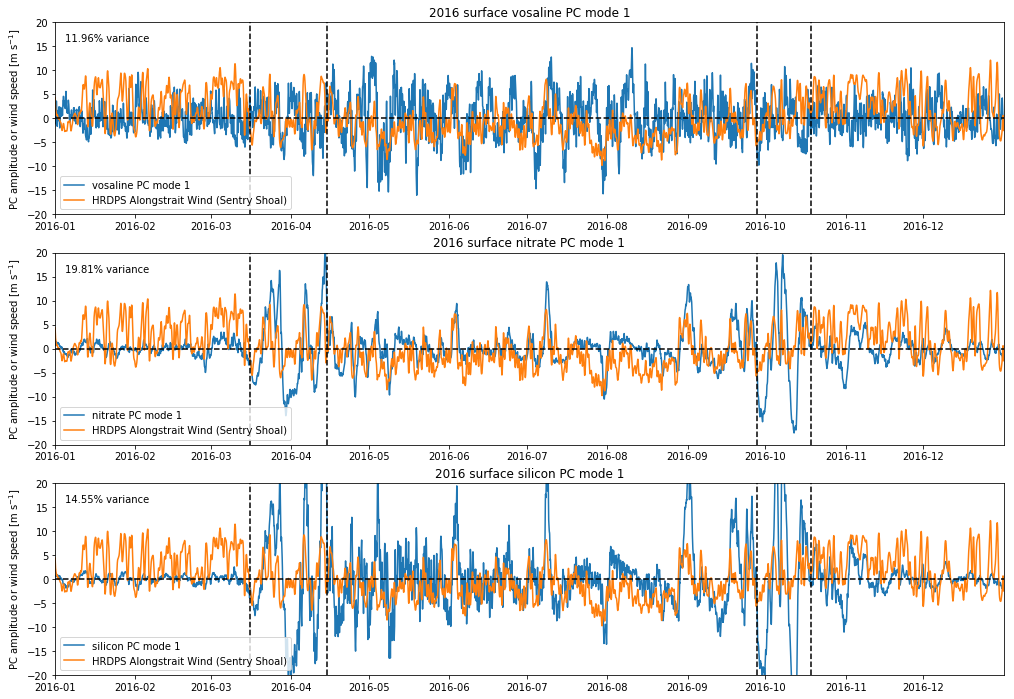

In [120]:
# Make figure
mode = 0
fig, axs = plt.subplots(3, 1, figsize=(17, 12))

for ax, qty in zip(axs, ['vosaline', 'nitrate', 'silicon']):

    ax.plot(time, -EOF[qty]['A'][:, mode]/5, label=f'{qty} PC mode {mode+1}')
    ax.plot(v_wind.time, signal.filtfilt(*signal.butter(2, 0.1), v_wind), label='HRDPS Alongstrait Wind (Sentry Shoal)')
    ax.plot([time[1800], time[1800]], [-20, 20], 'k--')
    ax.plot([time[2520], time[2520]], [-20, 20], 'k--')
    ax.plot([time[6500], time[6500]], [-20, 20], 'k--')
    ax.plot([time[7000], time[7000]], [-20, 20], 'k--')
    ax.plot([time[0], time[-1]], [0, 0], 'k--')
    ax.set_xlim(timerange)
    ax.set_ylim([-20, 20])
    ax.set_ylabel('PC amplitude or wind speed [m s$^{-1}$]')
    PercentVar = EOF[qty]['var'][mode]*100
    ax.text(0.01, 0.9, f'{PercentVar:.2f}% variance', transform=ax.transAxes)
    #PercentVar = EOF[qty]['Rvar'][mode]*100
    #ax.text(0.01, 0.82, f'{PercentVar:.2f}% variance rotated', transform=ax.transAxes)
    ax.set_title(f'2016 surface {qty} PC mode {mode+1}')
    ax.legend(loc=3)

plt.show()

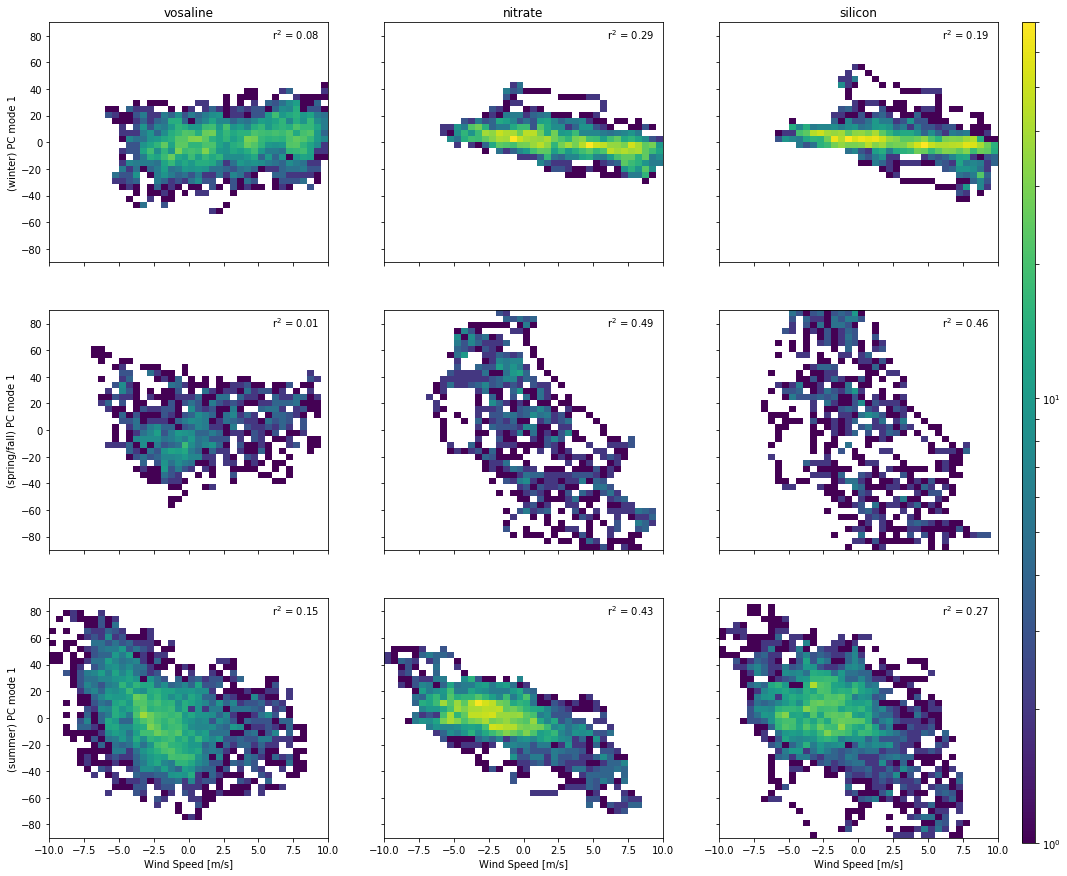

In [151]:
# Make figure
mode = 0
indices = [
    list(range(1800)) + list(range(7000, 8784)),
    list(range(1800, 2520)) + list(range(6500, 7000)),
    list(range(2520, 6500)),
]
qtys = ['vosaline', 'nitrate', 'silicon']

fig, axs = plt.subplots(3, 3, figsize=(17, 15))
for col, qty in enumerate(qtys):
    axs[0, col].set_title(qty)
    axs[2, col].set_xlabel('Wind Speed [m/s]')
    axs[0, col].xaxis.set_ticklabels('')
    axs[1, col].xaxis.set_ticklabels('')

for row, index, season in zip(axs, indices, ['winter', 'spring/fall', 'summer']):
    row[0].set_ylabel(f'({season}) PC mode 1')
    row[1].yaxis.set_ticklabels('')
    row[2].yaxis.set_ticklabels('')
    for ax, qty in zip(row, qtys):
        x = signal.filtfilt(*signal.butter(2, 0.1), v_wind)[index]
        y = EOF[qty]['A'][:, 0][index]
        fit = sm.OLS(np.roll(y, -15), sm.add_constant(x)).fit()
        c = ax.hist2d(
            x, np.roll(y, -15), norm=colors.LogNorm(), bins=40, vmin=1, vmax=70, range=np.array([(-10, 10), (-90, 90)]),
        )
        ax.text(0.8, 0.93, f'r$^2$ = {fit.rsquared:.2f}', transform=ax.transAxes)

cax = fig.add_axes([0.92, 0.12, 0.01, 0.76])
plt.colorbar(c[3], cax=cax)

Plot Hindcast EOFs

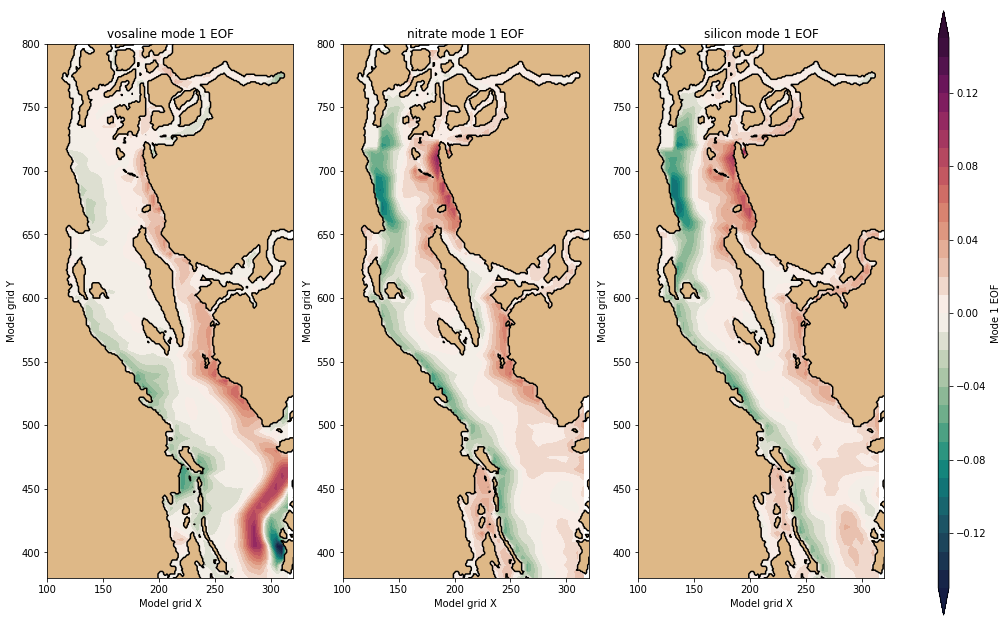

In [17]:
# Make figure
mode = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 12))

for ax, qty in zip(axs, ['vosaline', 'nitrate', 'silicon']):
    
    # Formatting
    ax.set_xlim(xslice)
    ax.set_ylim(yslice)
    ax.set_xlabel('Model grid X')
    ax.set_ylabel('Model grid Y')
    ax.set_title(f'{qty} mode {mode+1} EOF')
    viz_tools.set_aspect(ax)

    # Plot EOF
    c = ax.contourf(
        range(*xslice, 5), range(*yslice, 5), EOF[qty]['E'][mode], 
        levels=np.arange(-0.15, 0.151, 0.01),
        cmap=cmocean.cm.curl, extend='both',
    )
    
    # Plot landmask
    ax.contourf(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='k')
    
# Colorbar
cax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label=f'Mode {mode+1} EOF')

# Output
plt.show()

### 50 km cutoff

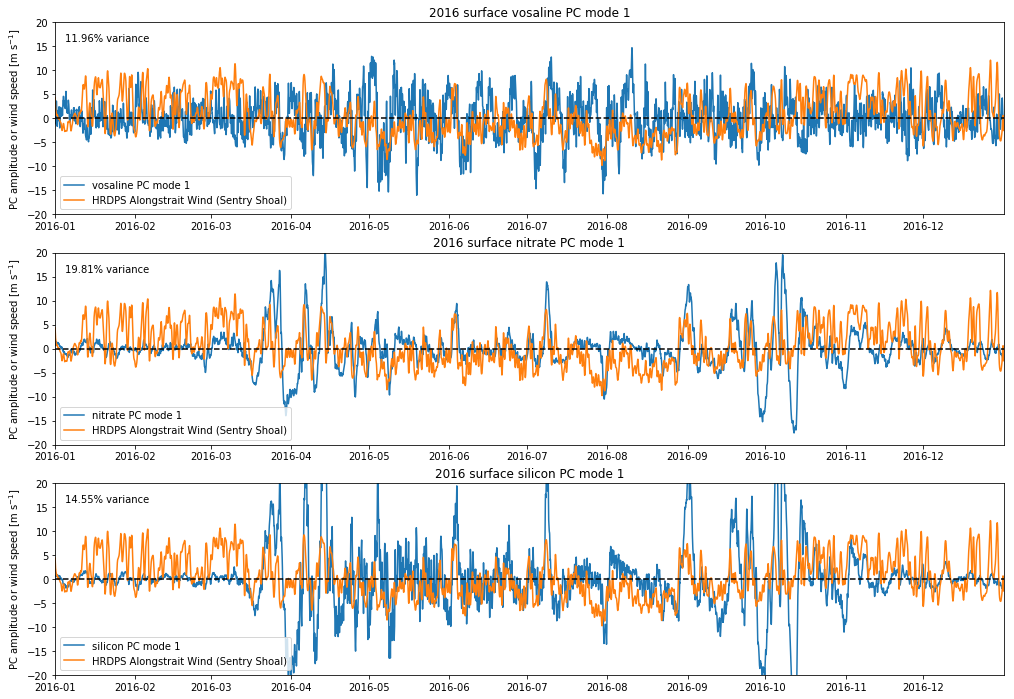

In [29]:
# Make figure
mode = 0
fig, axs = plt.subplots(3, 1, figsize=(17, 12))

for ax, qty in zip(axs, ['vosaline', 'nitrate', 'silicon']):

    ax.plot(time, -EOF[qty]['A'][:, mode]/5, label=f'{qty} PC mode {mode+1}')
    ax.plot(v_wind.time, signal.filtfilt(*signal.butter(2, 0.1), v_wind), label='HRDPS Alongstrait Wind (Sentry Shoal)')
    ax.plot([time[0], time[-1]], [0, 0], 'k--')
    ax.set_xlim(timerange)
    ax.set_ylim([-20, 20])
    ax.set_ylabel('PC amplitude or wind speed [m s$^{-1}$]')
    PercentVar = EOF[qty]['var'][mode]*100
    ax.text(0.01, 0.9, f'{PercentVar:.2f}% variance', transform=ax.transAxes)
    #PercentVar = EOF[qty]['Rvar'][mode]*100
    #ax.text(0.01, 0.82, f'{PercentVar:.2f}% variance rotated', transform=ax.transAxes)
    ax.set_title(f'2016 surface {qty} PC mode {mode+1}')
    ax.legend(loc=3)

plt.show()

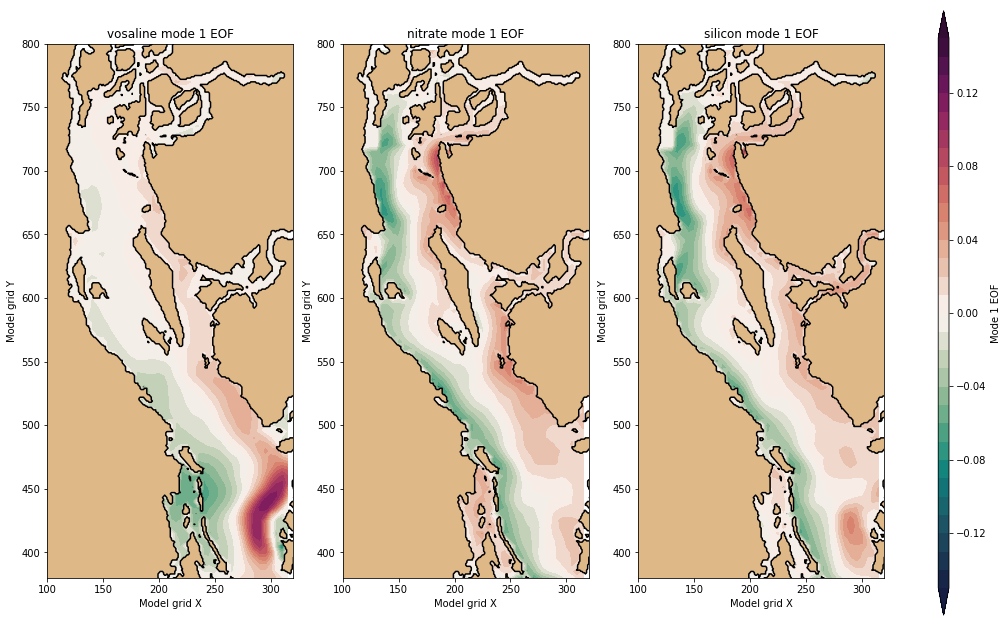

In [32]:
# Make figure
mode = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 12))

for ax, qty in zip(axs, ['vosaline', 'nitrate', 'silicon']):
    
    # Formatting
    ax.set_xlim(xslice)
    ax.set_ylim(yslice)
    ax.set_xlabel('Model grid X')
    ax.set_ylabel('Model grid Y')
    ax.set_title(f'{qty} mode {mode+1} EOF')
    viz_tools.set_aspect(ax)

    # Plot EOF
    c = ax.contourf(
        range(*xslice, 5), range(*yslice, 5), EOF[qty]['E'][mode], 
        levels=np.arange(-0.15, 0.151, 0.01),
        cmap=cmocean.cm.curl, extend='both',
    )
    
    # Plot landmask
    ax.contourf(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='k')
    
# Colorbar
cax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label=f'Mode {mode+1} EOF')

# Output
plt.show()

## Passive Tracer EOFs

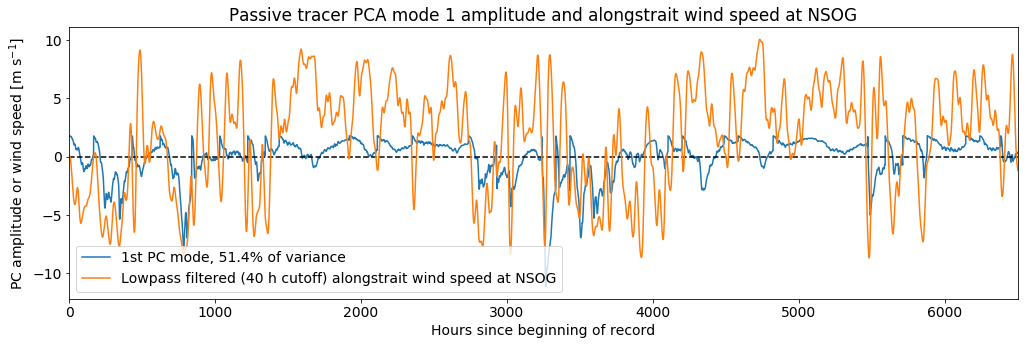

In [286]:
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(A[:, 0], label=f'1st PC mode, {100*PercentVar[0]:.1f}% of variance')
ax.plot([0, 6500], [0, 0], 'k--')
ax.plot(signal.filtfilt(*signal.butter(2, 0.05), -V), label='Lowpass filtered (40 h cutoff) alongstrait wind speed at NSOG')
ax.set_xlim([0, 6500])
ax.set_ylabel('PC amplitude or wind speed [m s$^{-1}$]')
ax.set_xlabel('Hours since beginning of record')
ax.set_title('Passive tracer PCA mode 1 amplitude and alongstrait wind speed at NSOG')
ax.legend(loc=3)
fig.savefig('/home/bmoorema/Desktop/PC_wind.pdf', dpi=300, bbox_inches='tight')

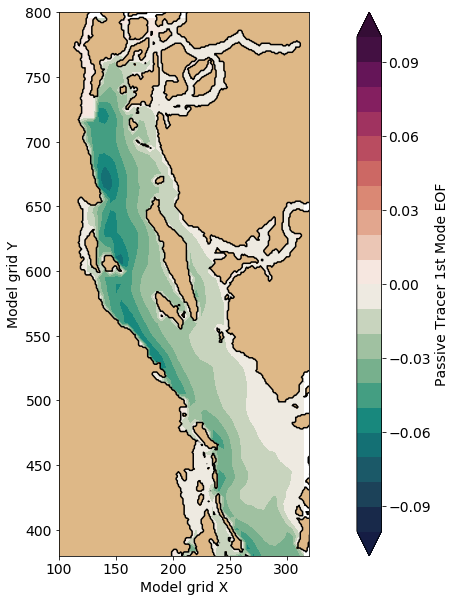

In [278]:
# Plot Rotated
EOF = []
for mode in range(2):
    EOF.append(np.zeros(mask.nav_lon.shape))
    for y, x, val in zip(gridy, gridx, E_T[mode, :]):
        EOF[mode][y, x] = val
    EOF[mode] = EOF[mode][slice(*yslice), slice(*xslice)][::subfac, ::subfac]
fig, ax = plt.subplots(1, 1, figsize=(17, 10))
c = ax.contourf(range(*xslice, 5), range(*yslice, 5), EOF[0], levels=np.arange(-0.1, 0.101, 0.01), cmap=cmocean.cm.curl, extend='both')
ax.contourf(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='burlywood')
ax.contour(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='k')
ax.set_xlim(xslice)
ax.set_ylim(yslice)
ax.set_xlabel('Model grid X')
ax.set_ylabel('Model grid Y')
viz_tools.set_aspect(ax)
fig.colorbar(c, label='Passive Tracer 1st Mode EOF')
plt.show()
fig.savefig('/home/bmoorema/Desktop/EOF.pdf', dpi=300, bbox_inches='tight')

In [99]:
filenames = [
    '/data/vdo/MEOPAR/completed-runs/stats-runs/21sep14/SalishSea_1h_20140921_20140927_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/15oct14/SalishSea_1h_20141015_20141025_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03dec14/SalishSea_1h_20141203_20141211_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/29jun15/SalishSea_1h_20150629_20150706_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/13jul15/SalishSea_1h_20150713_20150722_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/27aug15/SalishSea_1h_20150827_20150903_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/24jul16/SalishSea_1h_20160724_20160802_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/02aug16/SalishSea_1h_20160802_20160828_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03apr17/SalishSea_1h_20170403_20170407_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/10jun17/SalishSea_1h_20170610_20170616_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/23jul17/SalishSea_1h_20170723_20170728_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/12sep17/SalishSea_1h_20170912_20170916_ptrc_T.nc',
]

filenames_all = [
    '/data/vdo/MEOPAR/completed-runs/stats-runs/21sep14/SalishSea_1h_20140921_20140927_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/15oct14/SalishSea_1h_20141015_20141025_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/27nov14/SalishSea_1h_20141127_20141204_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03dec14/SalishSea_1h_20141203_20141211_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/23dec14/SalishSea_1h_20141223_20141230_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/16apr15/SalishSea_1h_20150416_20150423_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/25apr15/SalishSea_1h_20150425_20150429_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/30apr15/SalishSea_1h_20150430_20150503_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03jun15/SalishSea_1h_20150603_20150622_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/29jun15/SalishSea_1h_20150629_20150706_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/13jul15/SalishSea_1h_20150713_20150722_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/09aug15/SalishSea_1h_20150809_20150824_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/27aug15/SalishSea_1h_20150827_20150903_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/13nov15/SalishSea_1h_20151113_20151125_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/13dec15/SalishSea_1h_20151212_20151215_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/23dec15/SalishSea_1h_20151223_20151226_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/10jan16/SalishSea_1h_20160110_20160206_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/26mar16/SalishSea_1h_20160326_20160329_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03may16/SalishSea_1h_20160503_20160514_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/17may16/SalishSea_1h_20160517_20160520_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/24jul16/SalishSea_1h_20160724_20160802_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/02aug16/SalishSea_1h_20160802_20160828_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/29dec16/SalishSea_1h_20161229_20170102_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03apr17/SalishSea_1h_20170403_20170407_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/10jun17/SalishSea_1h_20170610_20170616_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/19jun17/SalishSea_1h_20170619_20170629_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/08jul17/SalishSea_1h_20170708_20170711_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/23jul17/SalishSea_1h_20170723_20170728_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/17dec17/SalishSea_1h_20171217_20171221_ptrc_T.nc',
]

In [104]:
bar = utilities.statusbar('Loading ...')
tracer = np.empty((0, tmask[0].sum()))
for filename in bar(filenames_all):
    trace = xr.open_dataset(filename).isel(deptht=0, y=slice(*yslice), x=slice(*xslice)).mytracer3
    tracer = np.concatenate((tracer, trace.values[:, ::subfac, ::subfac].reshape(trace.shape[0], nwater)[:, tmask[0]]), axis=0)
with open('/home/bmoorema/Desktop/tracer_backup', 'wb') as output_file:
    pickle.dump({'tracer': tracer}, output_file)

Loading ... 100% (29 of 29) |##############################################|Time: 0:21:50


In [106]:
# Calculate EOFs
Z = tracer - tracer.mean(axis=0)[np.newaxis, :]
A_prime, sqrtL, E_T = np.linalg.svd(Z, full_matrices=False)
A = A_prime.dot(np.diag(sqrtL))
R = varimax(A)
B = A.dot(R)
U = E_T.T.dot(R)
PercentVar = sqrtL**2/(sqrtL**2).sum()

In [24]:
Quadra = '/data/vdo/MEOPAR/completed-runs/candidates/quadra/jun15lake/SalishSea_1h_20150531_20150624_ptrc_T.nc'
Baynes = '/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15/SalishSea_1h_20150424_20150429_ptrc_T.nc'

In [30]:
Baynes = xr.open_dataset(
    '/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15/SalishSea_1h_20150424_20150429_ptrc_T.nc'
)
Baynes_Lake = xr.open_dataset(
    '/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15lake/SalishSea_1h_20150424_20150429_ptrc_T.nc'
)

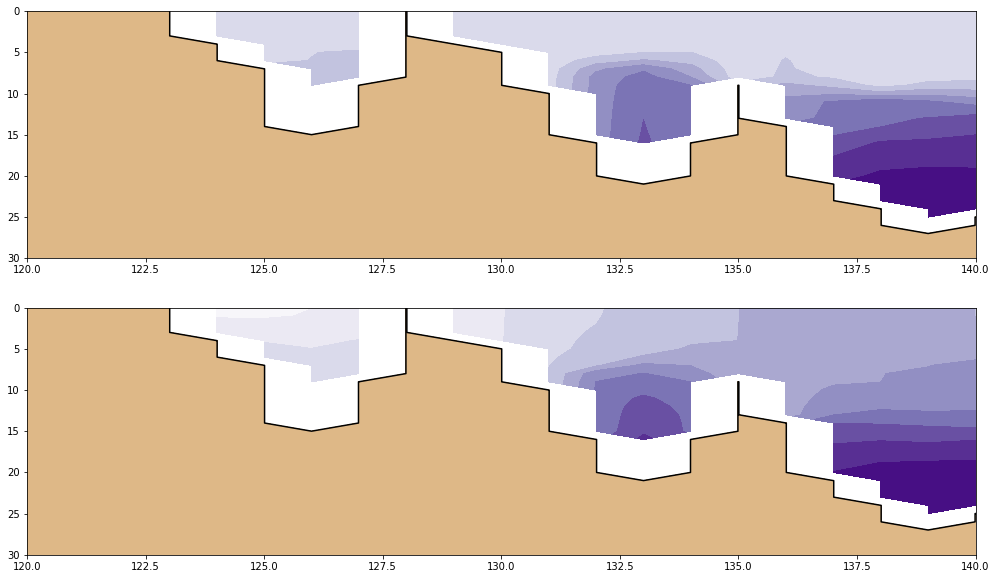

In [80]:
yi = 598
fig, axs = plt.subplots(2, 1, figsize=(17, 10))

for ax, obj in zip(axs, [Baynes, Baynes_Lake]):
    ax.contourf(
        np.ma.masked_where(mask.tmask.isel(t=0, y=yi)==False, obj.mytracer3.isel(time_counter=100, y=yi)),
        levels=np.arange(0, 1.1, 0.1), cmap='Purples',
    )
    ax.contourf(mask.tmask.isel(t=0, y=yi), levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(mask.tmask.isel(t=0, y=yi), levels=[-0.01, 0.01], colors='k')
    ax.set_ylim([30, 0])
    ax.set_xlim([120, 140])

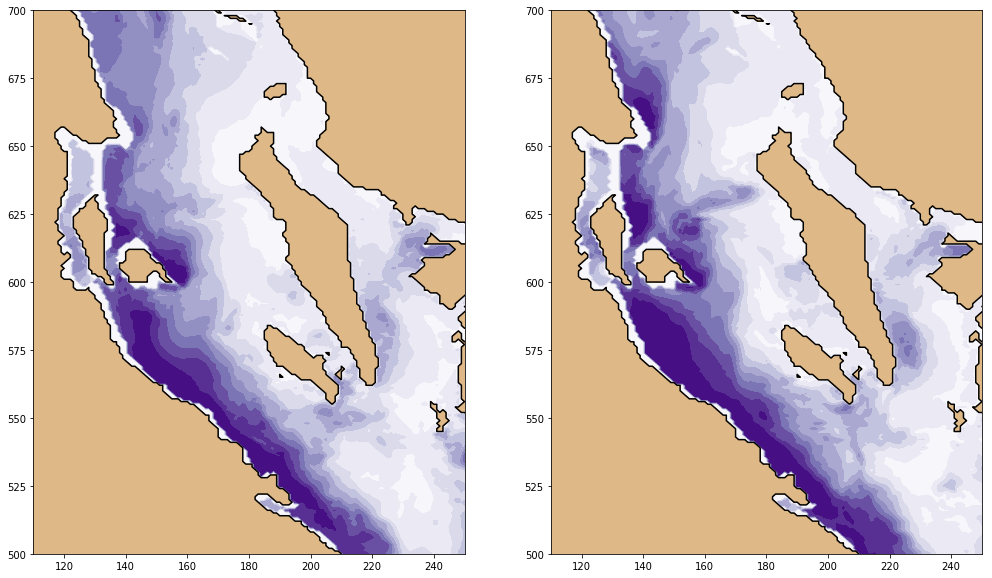

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(17, 10))

for ax, obj in zip(axs, [Baynes, Baynes_Lake]):
    c = ax.contourf(obj.mytracer3.isel(time_counter=100, deptht=15), levels=np.arange(0, 1.1, 0.1), cmap='Purples')
    ax.contourf(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([110, 250])
    ax.set_ylim([500, 700])

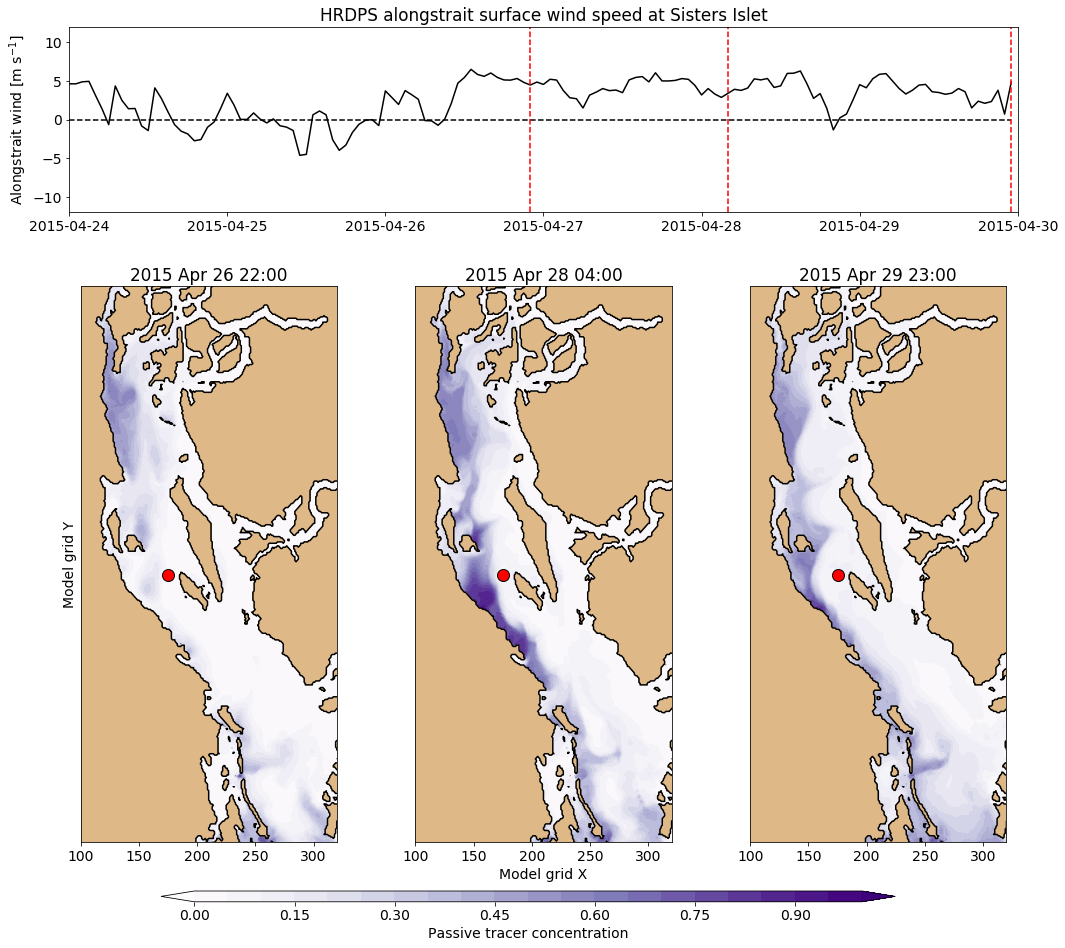

In [491]:
filename = Baynes
#time_index = [220, 280, 320]
time_index = [70, 100, 143]
#xlim = ['2015 Jun 4', '2015 Jun 17']
xlim = ['2015 Apr 24', '2015 Apr 30']
wind_station = 'Sisters Islet'

fig = plt.figure(figsize=(17, 15))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 3])
ax_top = fig.add_subplot(gs[0, :])
ax_bottom = [fig.add_subplot(gs[1, col]) for col in range(3)]
cax = fig.add_axes([0.2, 0.07, 0.6, 0.01])
ax_bottom[1].set_xlabel('Model grid X')
ax_bottom[0].set_ylabel('Model grid Y')

j, i = places.PLACES[wind_station]['GEM2.5 grid ji']
v_wind = GEM.sel(time=slice(*filename.split('_')[2:4])).isel(gridY=j, gridX=i).v_wind
ax_top.plot(v_wind.time, v_wind, 'k-')
ax_top.plot(v_wind.time, np.zeros(len(v_wind.time)), 'k--')
for t in time_index:
    time_i = nc_tools.xarraytime_to_datetime(v_wind.time.isel(time=t))
    ax_top.plot([time_i, time_i], [-12, 12], 'r--')
ax_top.set_xlim(xlim)
ax_top.set_ylim([-12, 12])
ax_top.set_ylabel('Alongstrait wind [m s$^{-1}$]')
ax_top.set_title(f'HRDPS alongstrait surface wind speed at {wind_station}')

Run = xr.open_dataset(filename).mytracer3.isel(deptht=0)
for ax, t in zip(ax_bottom, time_index):
    
    c = ax.contourf(Run.isel(time_counter=t), cmap='Purples', levels=np.arange(0, 1.01, 0.05), extend='both')
    ax.contourf(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='k')
    j, i = places.PLACES[wind_station]['NEMO grid ji']
    ax.plot(i, j, 'ro', markersize=12, markeredgecolor='k', linewidth=3)
    ax.set_xlim(xslice)
    ax.set_ylim(yslice)
    title = nc_tools.xarraytime_to_datetime(v_wind.isel(time=t).time).strftime('%Y %b %d %H:%M')
    ax.set_title(title)
    viz_tools.set_aspect(ax)
    if t != 220:
        ax.yaxis.set_ticks([])
        
fig.colorbar(c, cax=cax, orientation='horizontal', label='Passive tracer concentration')
plt.show()
fig.savefig('/home/bmoorema/Desktop/Baynes.pdf', dpi=300, bbox_inches='tight')